# IA898A - Processamento Digital de Imagens

## Projeto Final

## Reconhecimento de Teclas de Piano enquanto são tocadas

#### 103322 - Marcio Albano Hermelino Ferreira 
#### 135685 - Fernanda Caldas Correia 

[1. Dataset](#1)  
> [1.1.Geração dos frames originais](#11)  
[1.2. Obtenção das áreas de interesse](#12)  

[2. Algoritmo](#2)
> [2.1. Background Subtraction](#21)  
[2.2. Diferenças entre imagens](#22)  
[2.3. Mapeamento do teclado](#23)  
[2.4. Mapeamento dos caracteres](#24)
    
[3. Reconhecimento](#3)  
> [3.1. Notas do teclado](#31)  
[3.2. Caracteres](#32)

[4. Resultados](#4)
> [4.1. Análise qualitativa dos resultados](#41)  
[4.2. Análise quantitativa dos resultados](#42)



<a id='1'></a>

<a id='1'></a>
# 1. Dataset

Inicialmente, tentamos fazer a aquisição do vídeo utilizando câmeras, mas as imagens coletadas não ficaram boas para a reconhecimento precisa das formas das teclas pretas. Os fatores que contribuiram para isso foram o posicionamento da câmera e a iluminação. Para a obtenção de resultados mais satisfatórios, foi necessário obter um vídeo que possuía uma leve inclinação ao invés da câmera estar com uma vista superior perpendicular ao plano das teclas (sendo esse último o caso da nossa tentativa de aquisição própria). Para facilitar a análise da eficácia do algoritmo, também optamos por eum vídeo em que as notas que estavam sendo tocadas fossem indicadas através da notação de cifras (C=Dó, D=Ré, E=Mi..). Dessa forma, já temos no vídeo de teste um ground truth para avaliação.

O vídeo utilizado foi encontrado no YouTube: https://www.youtube.com/watch?v=WE0bFm4RPPU.

<a id='11'></a>
## 1.1.Geração dos frames originais

A partir do vídeo, obtivemos um total de 14.018 frames. Os frames que são utilizados, de fato, são os primeiros 13.527 pois do 13.528 ao 14.017 são do trecho de comentários finais do canal Piano Keyz, o qual é responsável pelo vídeo.

In [2]:
import cv2
vidcap = cv2.VideoCapture('radioactive.mp4')
frm = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in range(frm):
    success,image = vidcap.read()
    cv2.imwrite('Frames Originais/original%d.jpg' %i, image)

<a id='12'></a>
## 1.2. Obtenção das áreas de interesse

O nosso objetivo é reconhecer no teclado apenas o movimento das teclas enquanto estão sendo pressionadas. Para isso, isolamos a região de cima do mesmo (em verde, dos pixels da linha 675 à linha 775) pois é a que tem menos incidência de aparição da mão. A mão só atrapalharia o reconhecimento.

Além dessa região do teclado, isolamos, para analisar separadamente, o trecho (em vermelho, dos pixels da linha 610 à linha 660) que contém os caracteres das notas.

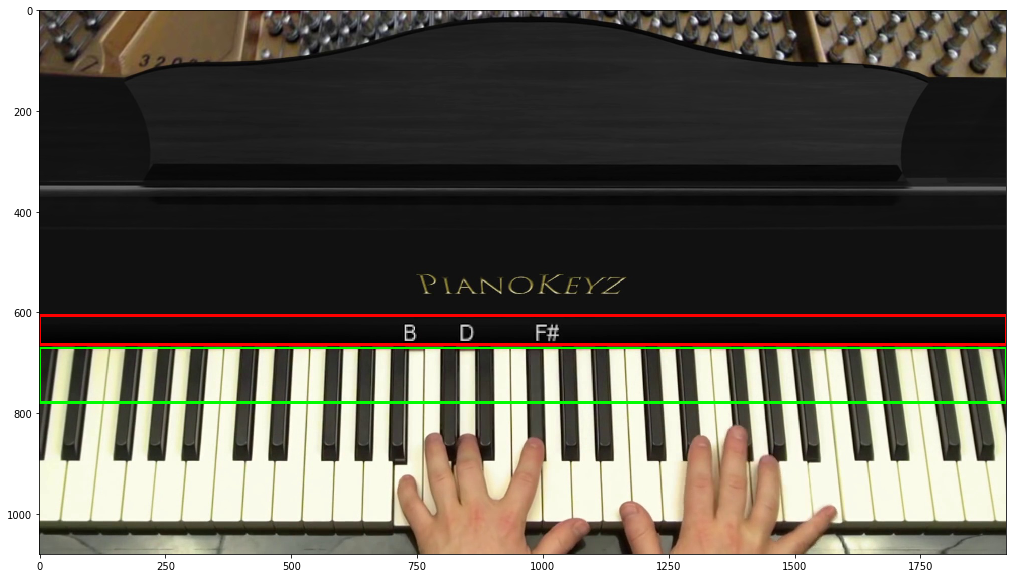

In [12]:
import matplotlib.pyplot as plt

image = cv2.imread('Frames Originais/original258.jpg')
cv2.rectangle(image, (0, 675-4), (1920, 775+4), (0, 255, 0), 4)
cv2.rectangle(image, (0, 610-4), (1920, 660+4), (0, 0, 255), 4)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,10))
plt.imshow(image)

<a id='2'></a>
# 2. Algoritmo

A base da construção do projeto consiste em duas técnicas de processamento de imagens: o background subtraction e o reconhecimento de difenças entre imagens.

<a id='21'></a>
## 2.1. Background subtraction

Para evidenciar as teclas que estavam sendo tocadas, escolhemos a técnica de **background subtraction** . Ela consiste na separação do que é fundo da imagem *(background)*, ou objetos estáticos, e do que é informação de primeiro plano *(foreground)*, que corresponde aos objetos que estão se movendo em um vídeo. No nosso caso, serão reconhecidas as mudanças entre um frame de referência (momento em que não há nenhuma tecla sendo apertada) e o frame que se deseja analisar. Ao realizar a diferença, o que sobrará serão as teclas que foram apertadas.

Existem métodos diversos para a implementação do background subtraction, e nós optamos por utilizar a função BackgroundSubtractorMOG2, da biblioteca OpenCV. Ela é implementada de acordo com o método proposto por Z. Zivkovic [1], que é adaptativo e usa uma mistura de densidade de probabilidade gaussiana.

Uma vez obtido cada frame a partir do background subtraction, eliminamos o ruído através do processo conhecido como *opening* (uma erosão seguida de uma dilatação) e transfomamos em imagem binária para facilitar a identificação das diferenças.

In [13]:
import numpy as np

def kern(n):
    return np.ones(n*n).reshape(n,n)

cap = cv2.VideoCapture('radioactive.mp4')
frm = 13527

fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = False)

for i in range(int(frm)):
    ret, frame = cap.read()        
    fgmask = fgbg.apply(frame)
    fgmask = fgmask[675:775,:]
    
    opening = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kern(4))
    ret,thresh1 = cv2.threshold(opening,210,255,cv2.THRESH_BINARY)
    cv2.imwrite('Background Subtraction/bg_sub%d.jpg' %i, thresh1)
        
cap.release()

<a id='22'></a>
## 2.2. Diferença entre imagens

Essa função possui duas entradas de mesmo tamanho e tipo:  
1. Uma imagem de base: um frame que representa o background. Ou seja, um frame preenchido apenas com zeros;
2. A imagem que detecta o movimento. Ou seja, um frame com uma tecla pressionada. 

O primeiro passo é o cálculo do Structural Similarity Index (SSIM) entre as duas imagens, o qual retorna o índice de similaridades entre as imagens (um valor entre -1 e 1) e a imagem de diferenças. Depois, ocorre transformação da imagem de diferenças em uma imagem binária e, a partir dela, são obtidos os contornos das diferenças. Por fim, é obtida a localização de cada contorno (ou diferença). Como um único frame pode ter mais de uma tecla pressionada, criamos vetores paras as coordenadas do começo das diferenças e para o tamanho, em pixels, dessas diferenças.

A mesma função é utilizada o reconhecimento das notas em caracteres. As entradas são:  
1. Imagem base preenchida com zeros;  
2. Imagem binária da região do piano que contém os caracteres.

A função retorna a localização das diferenças.

In [16]:
from skimage.measure import compare_ssim
import imutils
import matplotlib.image as mpimg
from PIL import Image

def img_diff(imageA, imageB):
    #Coordenadas do começo das diferenças
    x = np.zeros((1,10))
    y = np.zeros((1,10))
    
    #Tamanho das diferenças em pixels
    w = np.zeros((1,10))
    h = np.zeros((1,10))

    #Cálculo do SSIM
    (score, diff) = compare_ssim(imageA, imageB, full=True)
    diff = (diff * 255).astype("uint8")

    #Threshold e detecção dos contornos
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    i = 0
    for c in cnts:
        #Localização dos contornos
        (x_aux, y_aux, w_aux, h_aux) = cv2.boundingRect(c)
        
        #Limiar para que uma diferença seja considerada uma tecla pressionada
        
            #w_aux = 25 é o comprimento mínimo que a tecla deve ter
        
            #y_aux = 5 é a altura máxima que a diferença deve ter. Isso evita que parte da mão seja lida 
            #como uma tecla pressionada
        if w_aux > 25 and y_aux < 5:
            cv2.rectangle(imageB, (x_aux, y_aux), (x_aux + w_aux, y_aux + h_aux), (0, 255, 0), 2)
            x[0][i] = x_aux
            y[0][i] = y_aux
            w[0][i] = w_aux
            h[0][i] = h_aux
            i += 1
        
    return x, y, w, h

Esse código foi adaptado de [6].

<a id='23'></a>
## 2.3. Mapeamento do teclado

Utilizamos como base o primeiro frame do vídeo pois não contem nenhuma tecla pressionada. A região de interesse foi isolada e transformada em binária.

In [18]:
img = cv2.imread('Frames Originais/original0.jpg', 0)
img_cut = img[675:775,:]

ret,thresh = cv2.threshold(img_cut,210,255,cv2.THRESH_BINARY)
cv2.imwrite('basethre.jpg',thresh)

True

No entanto,a imagem de base gerada acima possui algumas regiões brancas dentro de teclas pretas e regiões pretas dentro de teclas brancas. Isso tornaria inviável o mapeamento de cada tecla branca e cada tecla preta através do algoritmo que implementamos, pois o mesmo se baseia em diferenciar regiões brancas das regiões pretas para classificar o tipo da tecla. Então editamos a imagem utilizando um software para contornar o problema. Abaixo, a imagem editada.

<center><img src="base.jpg"></center>

In [20]:
#altura do teclado
r = 100
base = cv2.imread('base.jpg', 0)

#Brancas
    #número de teclas brancas que aparecem na tela
N = 33

    #vetor que indica o início de cada tecla branca
brancas = np.zeros((r, N))
b_track = 0

    #vetor que informa o tamanho de cada tecla branca
brancas_tam = np.zeros((r, N))
b_tam = 0

#Pretas
    #número de teclas brancas que aparecem na tela
M = 25

    #vetor que indica o início de cada tecla preta
pretas = np.zeros((r, M))
p_track = 0

    #vetor que informa o tamanho de cada tecla preta
pretas_tam = np.zeros((r, M))
p_tam = 0

row, col = base.shape

#Distribuição das teclas ao longo do teclado
teclado = np.zeros((1, M + N))

for j in range(r):
    b_track = 0
    b_tam = 0
    p_track = 0
    p_tam = 0
    t_track = 0
    
    for i in range(col):
        #região preta
        if base[j][i] < 210:
            #se o pixel anterior for branco, significa o início de uma tecla preta ou de uma linha
            if base[j][i-1] > 210:
                brancas_tam[j][b_track] = b_tam
                b_track += 1
                b_tam = 0
                p_aux = i
            
            #condição adicional pois o teclado começa com uma tecla preta
            if i==0:
                p_aux = i
            
            #incrementa o tamanho da região
            p_tam += 1

        #início de uma nova tecla branca
        if base[j][i] > 210:
            #diferenciação de uma tecla preta de uma linha de acordo com seu tamanho
            if p_tam > 10:
                #armazena o início de uma tecla preta
                pretas[j][p_track] = p_aux
                pretas_tam[j][p_track] = p_tam
                p_track += 1
                p_tam = 0
                teclado[0][t_track] = -1
                t_track += 1
    
            if base[j][i-1] < 210:
                brancas[j][b_track] = i
                
                teclado[0][t_track] = 1
                t_track += 1

            b_tam += 1

        if i == col - 1:
            pretas[j][p_track] = p_aux
            pretas_tam[j][p_track] = p_tam
            teclado[0][t_track] = -1

In [25]:
original = cv2.imread('Frames Originais/original0.jpg')
aux = np.copy(original[675:775,:,:])
r, c = base.shape
teclado_brancas = np.zeros((r, c, N), dtype='uint8')

#brancas
for i in range(N):
    for row in range(100):
        start = int(brancas[row][i])
        end = start + int(brancas_tam[row][i])
        aux[row,start:end] = (0, 255, 0)
        
        #Imagem de cada tecla separadamente para comparação posterior
        teclado_brancas[row,start:end,i] = 255 

    #cv2.imwrite('Mapeamento Teclado/brancas%d.jpg' %i, teclado_brancas[:,:,i])
    cv2.imwrite('Mapeamento Teclado/original_brancas%d.jpg' %i, aux)
    aux = np.copy(original[675:775,:,:])

<center><img src="original_brancas.gif"></center>

In [26]:
aux = np.copy(original[675:775,:,:])
r, c, = base.shape
teclado_pretas = np.zeros((100, c, M), dtype='uint8')

#pretas
for i in range(M):
    for row in range(100):
        start = int(pretas[row][i])
        end = start + int(pretas_tam[row][i])
        aux[row,start:end] = (0, 255, 0)
        
        #Imagem de cada tecla separadamente para comparação posterior
        teclado_pretas[row,start:end,i] = 255 
    
    #cv2.imwrite('Mapeamento Teclado/pretas%d.jpg' %i, teclado_pretas[:,:,i])
    cv2.imwrite('Mapeamento Teclado/original_pretas%d.jpg' %i, aux)
    aux = np.copy(original[675:775,:,:])

<center><img src="original_pretas.gif"></center>

<a id='24'></a>
## 2.4. Mapeamento dos caracteres

Isolamos a região que contém os caracters em cada frame.

In [27]:
frm = 13527

for i in range(int(frm)):
    img = cv2.imread('Frames Originais/original%d.jpg' %i, 0)
    img = img[610:660,:]
    
    ret,thresh = cv2.threshold(img,100,255,cv2.THRESH_BINARY)

    cv2.imwrite('Notas em caracteres/nota_carac%d.jpg' %i, thresh)

In [33]:
def img_diff_carac(imageA, imageB):
    x = np.zeros((1,10))
    y = np.zeros((1,10))
    w = np.zeros((1,10))
    h = np.zeros((1,10))

    (score, diff) = compare_ssim(imageA, imageB, full=True)
    diff = (diff * 255).astype("uint8")

    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    i = 0
    for c in cnts:
        (x_aux, y_aux, w_aux, h_aux) = cv2.boundingRect(c)
        
        if w_aux >10:
            x[0][i] = x_aux
            y[0][i] = y_aux
            w[0][i] = w_aux
            h[0][i] = h_aux
            i += 1
        
    return x, y, w, h

def cut_nota(img, x, w):
    if x!=0:
        start = int(x)
        end = int(x) + int(w)
        img_cut = img[:,start:end]
        return img_cut
    
    else: 
        return 0

A partir das imagens geradas acima, isolamos algumas notas usando a função img_diff_carac. Assim, pudemos obter os caracteres que servirão de base para o reconhecimento das notas.

Designamos:  
0 - C  
1 - D  
2 - E  
3 - F  
4 - G  
5 - A  
6 - B

sust0 - C#  
sust1 - D#   
sust2 - F#  
sust3 - G#  
sust4 - A#

No vídeo só aparecem as seguintes notas, que foram preenchidas para que notas do mesmo tipo tenham o mesmo tamanho.

<table><tr>
<td> <img src="1.jpg" alt="Drawing"/> </td>
<td> <img src="2.jpg" alt="Drawing"/> </td>
<td> <img src="5.jpg" alt="Drawing"/> </td>
<td> <img src="6.jpg" alt="Drawing"/> </td>
</tr></table>

<table><tr>
<td> <img src="sust0.jpg" alt="Drawing"/> </td>
<td> <img src="sust2.jpg" alt="Drawing"/> </td>
<td> <img src="sust3.jpg" alt="Drawing"/> </td>
</tr></table>

Todos os caracteres usados como base foram previamente carregados em uma matriz para facilitar o processamento.

In [28]:
#Molde dos caracteres
carac = np.zeros((50, 38, 8), dtype='uint8')
carac_sust = np.zeros((50, 65, 5), dtype='uint8')

for i in range(8):
    #Os caracteres C, F e G foram considerados como uma imagem de zeros
    if i ==1 or i == 2 or i == 5 or i ==6:
        carac[:,:,i] = cv2.imread('Notas em caracteres/Mapeamento/%d.jpg' %i, 0)

for i in range(5):
    #Os caracteres A# e D# foram considerados como uma imagem de zeros
    if i ==0 or i == 2 or i == 3:
        carac_sust[:,:,i] = cv2.imread('Notas em caracteres/Mapeamento/sust%d.jpg' %i, 0)

<a id='3'></a>
# 3. Reconhecimento


Nessa etapa, é feito o reconhecimento das teclas propriamente dito, a partir da imagem obtida com o background subtraction. São percorridos todos os frames do vídeo, e é calculada a diferença entre cada um dos frames e o frame de base. Caso encontre alguma diferença, será feita uma comparação entre cada diferença e todas as outras teclas. A que apresentar o maior indice de similaridade será a tecla reconhecida.

<a id='31'></a>
## 3.1. Notas do teclado

In [30]:
base = cv2.imread('Background Subtraction/bg_sub0.jpg', 0)
r, c = base.shape
#criado vetor com duas linhas para poder comparar as coisas na mesma imagem
fill = np.zeros((2*r + 20, c), dtype='uint8')

#no maximo 10 notas podem ser tocadas ao mesmo tempo
#entao o maximo de diferenças que podem ser detectadas é 10

comp = np.zeros((1, N + M, 10))

notas_tecla = np.zeros((int(frm), 7, 5), dtype='uint8')
notas_tecla_sust = np.zeros((int(frm), 5, 5), dtype='uint8')

aux = np.zeros((r, c), dtype='uint8')

frm = 13527

#percorrer todos frames
for i in range(frm):
    frame = cv2.imread('Background Subtraction/bg_sub%d.jpg' %i, 0)
    x, y, w, h = img_diff(base, frame)
    fill[:100,:] = frame
    
    for j in range(10):
        #caso tenha encontrado diferença, preenche o polígono de branco
        if x[0][j] != 0:
            start = int(x[0][j])
            end = start + int(w[0][j])
            aux[:,start:end] = 255
            
            #compara a região pintada  com regiões de mesmo tamanho para todas as notas.
            for k in range(N):
                comp[0, k, j] = compare_ssim(aux[:,start:end], teclado_brancas[:,start:end,k])
                
            for k in range(N, N + M):
                comp[0, k, j] = compare_ssim(aux[:,start:end], teclado_pretas[:,start:end,k - N])
            #pega a nota com a maior similaridade 
            row, col, depth = np.unravel_index(np.argmax(comp, axis=None), comp.shape)
            
            #vetor de comparação: todas teclas brancas e depois todas as pretas
            #para as brancas
            if col < N:
                o = (col+1)//7
                nota = (col+1)%7
                notas_tecla[i][nota][o] = 1
            #para as pretas        
            if col >= N:
                o = (col-N)//5
                nota = (col-N)%5
                notas_tecla_sust[i][nota][o] = 1
        
        comp = np.zeros((1, N + M, 10))
        aux = np.zeros((r, c), dtype='uint8')
        
        #testando se oa matriz de reconhecimento está funcionando
        if x[0][j]==0 and x[0][j-1]!=0:
            #indica a nota e qual oitava pertence  
            white, oitava = np.nonzero(notas_tecla[i])
            nz_white = white.shape[0]
            
            for s in range(nz_white):
                #localização da tecla reconhecida
                n = int(7*oitava[s] + white[s] - 1)
                
                #preenchimento com base no mapeamento de cada tecla
                for count in range(100):
                    start = int(brancas[count][n])
                    end = start + int(brancas_tam[count][n])
                    fill[120:120+count,start:end] = 255
                    
            nz_white = 0
            
            #indica a nota e qual oitava pertence        
            black, oitava = np.nonzero(notas_tecla_sust[i])
            nz_black = black.shape[0]
                
            for s in range(nz_black):
                #localização da tecla reconhecida
                n = int(5*oitava[s] + black[s])
                
                #preenchimento com base no mapeamento de cada tecla
                for count in range(100):
                    start = int(pretas[count][n])
                    end = start + int(pretas_tam[count][n])
                    fill[120:120+count,start:end] = 255
                    
            nz_black = 0
            
    #cv2.imwrite('teste teclado/teste%d.jpg' %i, fill)
    fill = np.zeros((r*2 + 20, c), dtype='uint8')

Vídeo para testar o reconhecimento das teclas a partir dos frames do background subtraction.

In [31]:
frm = 13527

height , width = fill.shape
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter('teste_teclado.mp4', fourcc, 10.0,(width,height))

for i in range(int(frm)):
    img = cv2.imread('teste teclado/teste%d.jpg' %i)
    video.write(img)
    
video.release()
cv2.destroyAllWindows()

Vídeo disponível em: https://youtu.be/w0gkvBmxAfo.

<a id='32'></a>
## 3.2. Caracteres

In [34]:
base = cv2.imread('Notas em caracteres/nota_carac0.jpg', 0)
linha, coluna = base.shape
frm = 13527

notas_carac = np.zeros((int(frm), 7), dtype='uint8')
notas_carac_sust = np.zeros((int(frm), 5), dtype='uint8')

#Divisão em oitavas, delimitando o inicio de cada uma delas
oit = np.array([[0, 368, 768, 1162, 1562]])
notas_carac_oit = np.zeros((int(frm), 7, 5), dtype='uint8')
notas_carac_sust_oit = np.zeros((int(frm), 5, 5), dtype='uint8')

#Imagens para testar o reconhecimento
fill = np.zeros((2*linha + 20, coluna), dtype='uint8')

for i in range(int(frm)):
    img = cv2.imread('Notas em caracteres/nota_carac%d.jpg' %i, 0)
    fill[:50,:] = img
    x, y, w, h = img_diff_carac(base, img)
    
    #Separação de cada frame por oitava para facilitar o teste
    fill[:50,366:370] = 255
    fill[:50,766:770] = 255
    fill[:50,1160:1164] = 255
    fill[:50,1560:1564] = 255
    
    ssim = np.zeros((1, 7))
    ssim_sust = np.zeros((1, 5))
    
    for j in range(10):
        if x[0][j] != 0:
            f = np.zeros((50, 38), dtype='uint8')
            fsust = np.zeros((50, 65), dtype='uint8')
            nota = cut_nota(img, x[0][j], w[0][j])
            c = nota.shape[1]
            
            #Preenchimento para que as duas notas a serem comparadas sejam do mesmo tamanho
            #Todas as notas naturais mapeadas tem formato (50, 38)
            if c < 38:
                aux = 38 - c
                f[:,aux//2: c + aux//2] = nota
                
                #comparação das notas naturais com cada caractere
                for k in range(7):
                    ssim[0][k] = compare_ssim(carac[:,:,k], f)
                
                row, col = np.unravel_index(np.argmax(ssim, axis=None), ssim.shape)
                notas_carac[i][col] += 1
                
                #Identificação da oitava da nota a partir da localização da diferença
                o = 4
                while o > -1:
                    if x[0][j] > oit[0][o]:
                        notas_carac_oit[i][col][o] = 1
                        break
                    o -= 1
                        
                white, oitava = np.nonzero(notas_carac_oit[i])

                nz = white.shape[0]
                
                #preenchimento da imagem para testar o reconhecimento
                for s in range(nz):
                    n = int(7*oitava[s] + white[s] - 1)
                    start = int(brancas[0][n])
                    fill[70:,start:start + 38] = carac[:,:,int(white[s])]
            
            #Todas as notas sustenidas mapeadas tem formato (50, 65)
            if c > 38:
                aux = 65 - c
                fsust[:,aux//2: c + aux//2] = nota
                
                #comparação das notas sustenidas com cada caractere
                for k in range(5):
                    ssim_sust[0][k] = compare_ssim(carac_sust[:,:,k], fsust)           

                row, col = np.unravel_index(np.argmax(ssim_sust, axis=None), ssim_sust.shape)
                notas_carac_sust[i][col] += 1
                
                #Identificação da oitava da nota a partir da localização da diferença
                o = 4
                while o > -1:
                    if x[0][j] > oit[0][o]:
                        notas_carac_sust_oit[i][col][o] = 1
                        break
                    o -= 1
                        
                black, oitava = np.nonzero(notas_carac_sust_oit[i])

                nz = black.shape[0]
                
                #preenchimento da imagem para testar o reconhecimento
                for s in range(nz):
                    n = int(5*oitava[s] + black[s])
                    start = int(pretas[0][n])
                    fill[70:,start:start + 65] = carac_sust[:,:,int(black[s])]
                        
    
    #cv2.imwrite('teste caracteres/teste%d.jpg' %i, fill)
    fill = np.zeros((2*linha + 20, coluna), dtype='uint8')

Por fim, é feita a escrita do arquivo de vídeo a partir dos frames processados.

In [35]:
height , width = fill.shape
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter('teste_caracteres.mp4', fourcc, 10.0,(width,height))

for i in range(int(frm)):
    img = cv2.imread('teste caracteres/teste%d.jpg' %i)
    video.write(img)
    
video.release()
cv2.destroyAllWindows()

Vídeo disponível em: https://youtu.be/ORyPSad5oO0.

<a id='4'></a>
# 4. Resultados

Fizemos a análise qualitativa através da geração de um vídeo com o preenchimento das teclas reconhecidas e a análise quantitativa através do cálculo do número de erros (por perda ou falso positivo) e número de acertos.

<a id='41'></a>
## 4.1. Análise qualitativa dos resultados

In [36]:
frm = 13527

for i in range(frm):
    frame = cv2.imread('Frames Originais/original%d.jpg' %i)
    
    white, oitava = np.nonzero(notas_tecla[i])
    nz_white = white.shape[0]
                
    for s in range(nz_white):
        n = int(7*oitava[s] + white[s] - 1)
        
        for count in range(100):
            start = int(brancas[count][n])
            end = start + int(brancas_tam[count][n])
            frame[675:775,start:end,:] = (0, 255, 0)

    nz_white = 0
                    
    black, oitava = np.nonzero(notas_tecla_sust[i])
    nz_black = black.shape[0]
                
    for s in range(nz_black):
        n = int(5*oitava[s] + black[s])
        
        for count in range(100):
            start = int(pretas[count][n])
            end = start + int(pretas_tam[count][n])
            frame[675:775,start:end,:] = (0, 255, 0)
                    
    nz_black = 0
    
    cv2.imwrite('Video final/final%d.jpg' %i, frame)

In [77]:
frm = 13527

frame = cv2.imread('Video final/final0.jpg')
height , width, depth = frame.shape
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter('video_final.mp4', fourcc, 10.0,(width,height))

for i in range(int(frm)):
    img = cv2.imread('Video final/final%d.jpg' %i)
    video.write(img)
    
video.release()
cv2.destroyAllWindows()

O resultado final do reconhecimento está disponível em: https://youtu.be/gra6CwIb_YQ.

<a id='42'></a>
## 4.2. Análise quantitativa dos resultados

A partir das matrizes geradas em 3.1.(Reconhecimento do teclado) e 3.2.(Reconhecimento dos caracteres),foi obtida uma matriz de comparação a partir das diferenças entre as duas matrizes, de modo que a matriz resultante tivesse apenas três possíveis valores:  -1, 1 e 2 correspondentes aos casos de perda(nota não reconhecida), acerto e falso positivo (nota reconhecida de maneira incorreta), respectivamente.

Dessa forma, foi possível gerar gráficos para a análise quantitativa:

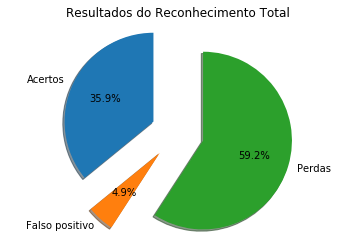

In [79]:
convert_tecla = notas_tecla.astype('float64')
convert_tecla_sust = notas_tecla_sust.astype('float64') 

convert_carac = notas_carac_oit.astype('float64')
convert_carac_sust = notas_carac_sust_oit.astype('float64')

comparacao_notas = 2*convert_tecla - convert_carac
comparacao_notas_sust = 2*convert_tecla_sust - convert_carac_sust

menos_um = (comparacao_notas==-1).sum() + (comparacao_notas_sust==-1).sum()
um = (comparacao_notas==1).sum() + (comparacao_notas_sust==1).sum()
dois = (comparacao_notas==2).sum() + (comparacao_notas_sust==2).sum()

labels = 'Acertos', 'Falso positivo', 'Perdas'
V = [um,dois,menos_um]

explode = (0.3, 0.3, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(V, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Resultados do Reconhecimento Total")
plt.show()


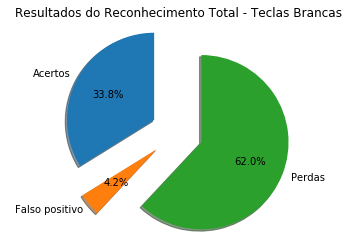

In [80]:
menos_um = (comparacao_notas==-1).sum()
um = (comparacao_notas==1).sum()
dois = (comparacao_notas==2).sum()

labels = 'Acertos', 'Falso positivo', 'Perdas'
V = [um,dois,menos_um]

explode = (0.3, 0.3, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(V, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Resultados do Reconhecimento Total - Teclas Brancas")
plt.show()

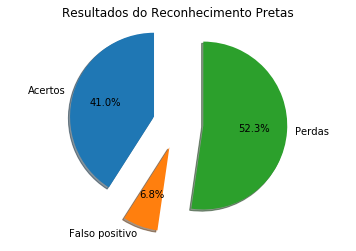

In [83]:
menos_um =(comparacao_notas_sust==-1).sum()
um = (comparacao_notas_sust==1).sum()
dois = (comparacao_notas_sust==2).sum()

labels = 'Acertos', 'Falso positivo', 'Perdas'
V = [um,dois,menos_um]

explode = (0.3, 0.3, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(V, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Resultados do Reconhecimento Pretas")
plt.show()

Observando os gráficos, notamos que há uma grande quantidade de perdas, o que pode nos levar a pensar que o algoritmo de reconhecimento foi muito ineficaz. Contudo, devemos atentar para o fato de que os dados apresentados na tela do vídeo e que foram utilizados como ground truth possuem um certo atraso, ou seja, o caractere da nota ainda fica na tela por alguns instantes mesmo depois que a nota não está mais sendo tocada. Esse foi um fator fundamental para justificar os resultados obtidos. Há uma outra questão que também deve ser observada, mas com o algoritmo de background subtraction. Quando uma tecla é pressionada por um periodo de tempo mais longo, existe a possibilidade dele ser interpretado como o próprio background, fazendo com que o reconhecimento seja falho.

## Referências


[1] ZIVKOVIC, Z. "Improved adaptive Gaussian mixture model for background subtraction" (2004); <br> 
[2] ZIVKOVIC, Z. "Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction" (2006) <br>
[3] SUTEPARUK, P. "Detection of Piano Keys Pressed in Video" <br>
[4] AKBARI, M.; CHENG, H. "claVision: Visual Automatic Piano Music Transcription" <br> 
[5] NISBET, A.; GREEN, R. "Capture of Dynamic Piano Performance with Depth Vision" <br>
[6] https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/